In [34]:

# code from https://thinkingneuron.com/how-to-use-artificial-neural-networks-for-classification-in-python/

#and  https://medium.com/luca-chuangs-bapm-notes/build-a-neural-network-in-python-binary-classification-49596d7dcabf


# modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils

# for modeling
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

In [35]:
# Load density data

MMS2_n = pd.read_csv('/Users/christylentz/iCloud/CU Boulder/CSCI 5622 Machine Learning/CSCI_5622_Project/MMS2_n.csv',
                     header = 0,names = ['times','n','date'],
                     parse_dates=['date'])


# load temperature data
MMS2_Tperp = pd.read_csv('/Users/christylentz/iCloud/CU Boulder/CSCI 5622 Machine Learning/CSCI_5622_Project/MMS2_Tperp.csv',
                     header = 0,names = ['times','Tperp','date'],
                     parse_dates=['date'])

MMS2_Tpara = pd.read_csv('/Users/christylentz/iCloud/CU Boulder/CSCI 5622 Machine Learning/CSCI_5622_Project/MMS2_Tpara.csv',
                     header = 0,names = ['times','Tpara','date'],
                     parse_dates=['date'])


Create a Predictive model that can tell if we are in the magnetosphere or not.

Target variable: Magnetosphere (MSP)
Predictors: density (n), parallel temperature (Tpara), perpendicular temperature (Tperp). 


yes we are in the magnetosphere = 1

no we are not in the magnetosphere = 0

In [45]:
# Magnteosphere time periods were identified by eye. 
# Find matching indices to classify density data set into being either 1 magnetosphere, or 0 not magnetosphere


# Identified magnetosphere time periods

NB_st_time = '2020-06-17/20:30:00'
NB_end_time = '2020-06-17/23:00:53'

NB_st_idx = MMS2_n.date.searchsorted(NB_st_time)
NB_end_idx = MMS2_n.date.searchsorted(NB_end_time)



# print(NB_st_idx)
# print(NB_end_idx)

# create an array the length of the classified data, fill with 0's
MSP = np.zeros(len(MMS2_n.date))


Magnetosphere_st_stop_times = ['2020-06-17/20:30:00','2020-06-17/21:16:31',
'2020-06-17/21:32:41','2020-06-17/21:35:30',
'2020-06-17/21:38:54','2020-06-17/21:41:40', 
'2020-06-17/21:49:00','2020-06-17/21:53:39',
'2020-06-17/21:56:49','2020-06-17/22:00:36',
'2020-06-17/22:04:52','2020-06-17/22:10:44',
'2020-06-17/22:13:28', '2020-06-17/22:16:47',
'2020-06-17/22:20:06','2020-06-17/22:23:55',
'2020-06-17/22:27:45','2020-06-17/22:30:56',
'2020-06-17/22:34:34','2020-06-17/22:37:37',
'2020-06-17/22:39:17','2020-06-17/22:43:45',
'2020-06-17/22:46:41','2020-06-17/22:49:33',
'2020-06-17/22:55:59','2020-06-17/23:00:53']

st_times = Magnetosphere_st_stop_times[::2]
end_times = Magnetosphere_st_stop_times[1::2]


# fill array with 1s during the identified msp times. 
for t in range(len(st_times)):
    st_idx_1 = MMS2_n.date.searchsorted(st_times[t])
    #print('start index:',st_idx_1)
    end_idx_1 = MMS2_n.date.searchsorted(end_times[t])
    #print('end index:',end_idx_1)
    MSP[st_idx_1:end_idx_1] = 1
   # print('\n')
    


n = np.array(MMS2_n.n[NB_st_idx:NB_end_idx])

NN_DF = pd.DataFrame(data = {"times": MMS2_n.times[NB_st_idx:NB_end_idx],
                             "n": MMS2_n.n[NB_st_idx:NB_end_idx],
                             "Tpara": MMS2_Tpara.Tpara[NB_st_idx:NB_end_idx],
                            "Tperp": MMS2_Tperp.Tperp[NB_st_idx:NB_end_idx],
                            "MSP":MSP[NB_st_idx:NB_end_idx]})
NN_DF








#print(NN_DF['MSP'].value_counts())

# there should be enough so that it performs better than a dummy model
#print(36800/(36800+23550))


,times,n,Tpara,Tperp,MSP
645,1.592426e+09,0.989079,525.85547,499.37415,1.0
646,1.592426e+09,0.963726,504.76862,515.45215,1.0
647,1.592426e+09,0.944500,487.18292,479.80856,1.0
648,1.592426e+09,0.953222,581.82440,515.65250,1.0
649,1.592426e+09,0.978770,516.98810,498.97446,1.0
...,...,...,...,...,...
60990,1.592435e+09,1.109043,396.39496,422.18692,1.0
60991,1.592435e+09,1.100456,392.12500,423.97350,1.0
60992,1.592435e+09,1.050140,374.55520,437.87630,1.0
60993,1.592435e+09,1.077892,323.79974,385.11502,1.0


In [46]:

# splitting data

#Predictors
X = NN_DF.drop(['MSP'], axis=1)



#target
y = NN_DF['MSP']



X = np.array(X)
y = np.array(y)




# standardize the predictors:
from sklearn.preprocessing import StandardScaler
PredictorScaler=StandardScaler()


# Storing the fit object for later reference
PredictorScalerFit=PredictorScaler.fit(X)
 
# Generating the standardized values of X and y
X=PredictorScalerFit.transform(X)



# Split the data into training and testing set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
 
# Quick sanity check with the shapes of Training and Testing datasets
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(42245, 4)
(42245,)
(18105, 4)
(18105,)


In [48]:
# use the sequential API to build model
model = Sequential()
model.add(Dense(16, input_shape=(X.shape[1],), activation='relu')) # Add an input shape! (features,)
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary() 

# compile the model
model.compile(optimizer='Adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])

# early stopping callback
# This callback will stop the training when there is no improvement in  
# the validation loss for 10 consecutive epochs.  
es = EarlyStopping(monitor='val_accuracy', 
                                   mode='max', # don't minimize the accuracy!
                                   patience=10,
                                   restore_best_weights=True)

# now we just update our model fit call
history = model.fit(X,
                    y,
                    callbacks=[es],
                    epochs=10, # you can set this to a big number!
                    batch_size=10,
                    validation_split=0.2,
                    shuffle=True,
                    verbose=1)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 16)                80        
                                                                 
 dense_16 (Dense)            (None, 16)                272       
                                                                 
 dense_17 (Dense)            (None, 1)                 17        
                                                                 
Total params: 369
Trainable params: 369
Non-trainable params: 0
_________________________________________________________________
Epoch 1/80
4828/4828 [==============================] - 3s 528us/step - loss: 0.2323 - accuracy: 0.9065 - val_loss: 0.4014 - val_accuracy: 0.8490
Epoch 2/80
4828/4828 [==============================] - 2s 505us/step - loss: 0.1338 - accuracy: 0.9497 - val_loss: 0.4727 - val_accuracy: 0.8228
Epoch 3/80
4828/4828 [======

In [47]:
classifier = Sequential()
# Defining the Input layer and FIRST hidden layer,both are same!
# relu means Rectifier linear unit function
classifier.add(Dense(units=10, input_dim=4, kernel_initializer='uniform', activation='relu'))
 
#Defining the SECOND hidden layer, here we have not defined input because it is
# second layer and it will get input as the output of first hidden layer
classifier.add(Dense(units=6, kernel_initializer='uniform', activation='relu'))
 
# Defining the Output layer
# sigmoid means sigmoid activation function
# for Multiclass classification the activation ='softmax'
# And output_dim will be equal to the number of factor levels
classifier.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))
 
# Optimizer== the algorithm of SGG to keep updating weights
# loss== the loss function to measure the accuracy
# metrics== the way we will compare the accuracy after each step of SGD
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
 
# fitting the Neural Network on the training data
MSPANN_Model=classifier.fit(X_train,y_train, batch_size=10 , epochs=10, verbose=1)
 
# fitting the Neural Network on the training data
MSPANN_Model=classifier.fit(X_train,y_train, batch_size=10 , epochs=10, verbose=1)


Epoch 1/10
4225/4225 [==============================] - 2s 408us/step - loss: 0.4017 - accuracy: 0.8373
Epoch 2/10
4225/4225 [==============================] - 2s 388us/step - loss: 0.3638 - accuracy: 0.8465
Epoch 3/10
4225/4225 [==============================] - 2s 394us/step - loss: 0.2873 - accuracy: 0.8739
Epoch 4/10
4225/4225 [==============================] - 2s 388us/step - loss: 0.2355 - accuracy: 0.9152
Epoch 5/10
4225/4225 [==============================] - 2s 399us/step - loss: 0.2062 - accuracy: 0.9241
Epoch 6/10
4225/4225 [==============================] - 2s 400us/step - loss: 0.1944 - accuracy: 0.9274
Epoch 7/10
4225/4225 [==============================] - 2s 391us/step - loss: 0.1880 - accuracy: 0.9286
Epoch 8/10
4225/4225 [==============================] - 2s 397us/step - loss: 0.1839 - accuracy: 0.9298
Epoch 9/10
4225/4225 [==============================] - 2s 391us/step - loss: 0.1795 - accuracy: 0.9301
Epoch 10/10
4225/4225 [==============================] - 2s 402u

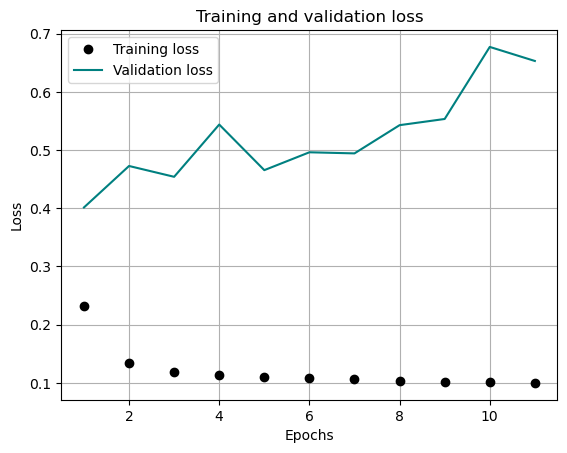

In [51]:
history_dict = history.history
# Learning curve(Loss)
# let's see the training and validation loss by epoch

# loss
loss_values = history_dict['loss'] # you can change this
val_loss_values = history_dict['val_loss'] # you can also change this

# range of X (no. of epochs)
epochs = range(1, len(loss_values) + 1) 

# plot
plt.plot(epochs, loss_values, 'ko', label='Training loss')
plt.plot(epochs, val_loss_values, 'teal', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

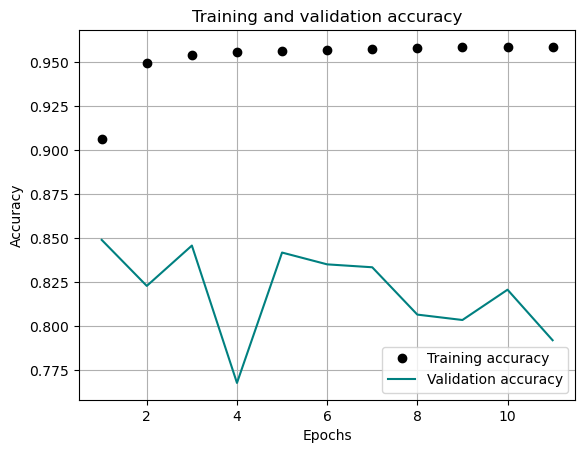

0.8489643931388855

In [52]:
# Learning curve(accuracy)
# let's see the training and validation accuracy by epoch

# accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# range of X (no. of epochs)
epochs = range(1, len(acc) + 1)

# plot
# "bo" is for "blue dot"
plt.plot(epochs, acc, 'ko', label='Training accuracy')
# orange is for "orange"
plt.plot(epochs, val_acc, 'teal', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# this is the max value - should correspond to
# the HIGHEST train accuracy
np.max(val_acc)

In [49]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# see how these are numbers between 0 and 1? 
model.predict(X) # prob of successes (survival)
np.round(model.predict(X),0) # 1 and 0 (survival or not)
y # 1 and 0 (survival or not)

# so we need to round to a whole number (0 or 1),
# or the confusion matrix won't work!
preds = np.round(model.predict(X),0)

# confusion matrix
print(confusion_matrix(y, preds)) # order matters! (actual, predicted)

## array([[490,  59],   ([[TN, FP],
##       [105, 235]])     [Fn, TP]])

print(classification_report(y, preds))
##               precision    recall  f1-score   support
## 
##            0       0.82      0.89      0.86       549
##            1       0.80      0.69      0.74       340
## 
##     accuracy                           0.82       889
##    macro avg       0.81      0.79      0.80       889
## weighted avg       0.81      0.82      0.81       889

1886/1886 [==============================] - 1s 282us/step
[[21314  2236]
 [ 2201 34599]]
              precision    recall  f1-score   support

         0.0       0.91      0.91      0.91     23550
         1.0       0.94      0.94      0.94     36800

    accuracy                           0.93     60350
   macro avg       0.92      0.92      0.92     60350
weighted avg       0.93      0.93      0.93     60350



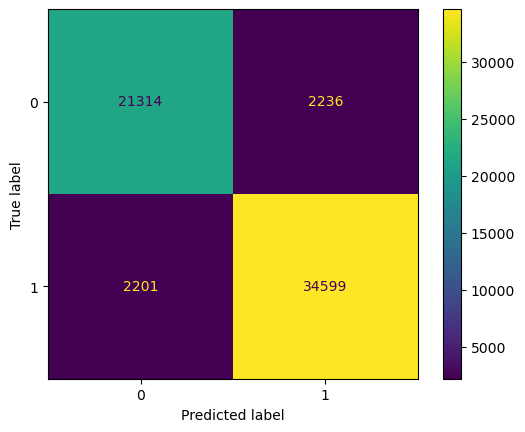

In [50]:
from sklearn.metrics import confusion_matrix

from sklearn.metrics import ConfusionMatrixDisplay


# import seaborn as sns # for statistical data visualization

# cm_matrix = pd.DataFrame(data = confusion_matrix(y, preds), columns=['Negative', 'Positive'], 
#                                  index=['Positive', 'Negative'])

# sns.heatmap(cm_matrix, annot = True, fmt='d', cmap='inferno')



cm = confusion_matrix(y, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()